In [1]:
!pip install python/

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install torch torchvision torchaudio

In [3]:
!pip install protobuf==3.20.1 #protobuf==3.20.3

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import google.protobuf
print(google.protobuf.__version__)

In [4]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

import torch

In [5]:
#env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe', base_port=63457)

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Found path: /data/Reacher_Linux_NoVis/Reacher.x86_64
Mono path[0] = '/data/Reacher_Linux_NoVis/Reacher_Data/Managed'
Mono config path = '/data/Reacher_Linux_NoVis/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents) # initialize the score (for each agent)
i = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    #print(actions)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
#     print(states[0])
#     print(actions[0:2])
#     print(actions2[0:2])
    i += 1
    if i >= 4 :                                        # Exit after 4 iterations.
         break
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


In [9]:
##Main code taken from Udacity's repository:
##https://github.com/udacity/deep-reinforcement-learning/
##

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


##Hidden layer's weights intialization
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        _input_layer = 128
        _hidden_1 = 256
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, _input_layer)
        self.fc2 = nn.Linear(_input_layer, _hidden_1)
        self.fc3 = nn.Linear(_hidden_1, action_size)
        
        #batchnorm
        self.bn_input = nn.BatchNorm1d(_input_layer)
        self.bn_hidden = nn.BatchNorm1d(_hidden_1)

        #Dropout
        self.dpout = nn.Dropout(p=0.20)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        #If there are multiple windows, the state will have them already concatenated
        #Input layer: Dense + Batchnorm + ReLU
        x = self.fc1(state) 
        x = self.bn_input(x)
        x = F.relu(x)

        #First hidden layer: Dense + ReLU
        x = self.fc2(x)
#         x = self.bn_hidden(x)
        x = F.relu(x)

        #Output layer: Dense  + Tanh
        x = self.fc3(x)
        out = torch.tanh(x)
        return out

    
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        _input_layer = 128
        _hidden_1 = 256
        self.seed = torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size, _input_layer)
        self.fc2 = nn.Linear(_input_layer + action_size, _hidden_1) #concat the action from the actor
        self.fc3 = nn.Linear(_hidden_1, 1)
        
        #batchnorm
        self.bn_input = nn.BatchNorm1d(_input_layer)
        
        #Dropout
        self.dpout = nn.Dropout(p=0.20)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #If there are multiple windows, the state will have them already concatenated
        #Input layer: Dense + Batchnorm + ReLU
        x = self.fcs1(state) 
        x = self.bn_input(x)
        x = F.relu(x)

        #First hidden layer Dense + ReLU
        #Concat state & action
        x = torch.cat((x, action), dim=1)
        x = self.fc2(x)
        x = F.relu(x)

        #Output layer: Dense
        out = self.fc3(x)
        return out

In [10]:
import numpy as np
import random
import math

import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
MIN_LATEST_PER_BATCH = 1 # 0 also works well but 1 worked better for these hyperparameters
MAX_LATEST_PER_BATCH = 4#3#2#5#4#5#6#5#4#3 # max number of latest experiences to add in each trainig batch

GAMMA = 0.95            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
TRAIN_EVERY = 20        # How many iterations to wait before updating target networks
NUM_AGENTS = 20         # How many agents are there in the environment

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, idle_steps, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
        self.max_latest_experiences = num_agents*idle_steps
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR) #, weight_decay=WEIGHT_DECAY)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        #Copy the weights from local to target networks
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)
        
        # Noise process
        self.noise = OUNoise((NUM_AGENTS, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, self.max_latest_experiences, MIN_LATEST_PER_BATCH, MAX_LATEST_PER_BATCH, random_seed)
        
        
    def step(self, states, actions, rewards, next_states, dones, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            # Save experience / reward for all the agents
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory

        if len(self.memory) > BATCH_SIZE and (len(self.memory) % self.max_latest_experiences) == 0:
            while self.memory.hasLatestExperiences():                
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)



    """
    def act(self, state, add_noise=True):        

        #Convert the state array to tensor
        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        #Perform a training step
        self.actor_local.train()
        #Add noise to the obtained action      
        if add_noise:
            for act in actions:
                act += self.noise.sample() #make sure each individual action has a unique noise added to it
        
        #Ensure the output is in the valid action's range [-1, 1]
        return np.clip(actions, -1, 1)
    """
    
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:            
            actions += self.noise.sample() #make sure each individual action has a unique noise added to it
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        # Get action from actor's network, given the NEXT state        
        actions_next = self.actor_target(next_states)
        # Use the obtained action as input to the critic's network, along with the NEXT state
        Q_targets_next = self.critic_target(next_states, actions_next).detach()
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        #Get the expected value from the critic's local network
        Q_expected = self.critic_local(states, actions)
        
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        #Gradient clipping
        ##torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)

        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        #Get the "best" action using the actor's local network, given current state
        actions_pred = self.actor_local(states)
        
        #Compute the loss by getting the expected value (V) from the critic's local network,
        #given the current state and the obtained action. 
        #Set it negative to perform gradient ascent?
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        #Gradient clipping
        ##torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
                
        

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, shape, seed, mu=0., theta=0.15, sigma=0.08):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(shape)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.rand(*x.shape)-0.5)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, max_latest_experiences, min_latest_per_batch, max_latest_per_batch, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        
        self.latest_experiences: list[self.experience] = []
        self.curr_latest_index = -1
        self.max_latest_experiences = max_latest_experiences
        self.max_latest_per_batch = max_latest_per_batch
        self.min_latest_per_batch = min_latest_per_batch
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
                
        
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(WeightedExperience(e,0))
        self.z1c = self.z1c + 1
        """
        
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        if len(self.memory) < self.max_latest_experiences:
            self.memory.append(e)
        else:
            self.latest_experiences.append(e) 
        
        """
        e = self.experience(state, action, reward, next_state, done)
        #self.memory.append(e)
        if len(self.memory) == BUFFER_SIZE:            
            self.first_index = (self.first_index + 1) % BUFFER_SIZE
        
        self.last_index = (self.last_index + 1) % BUFFER_SIZE

        if len(self.memory) < BUFFER_SIZE:
            self.memory.append(WeightedExperience(e,0))
        else:
            self.memory[self.last_index] = WeightedExperience(e,0)
        
        self.z1c = self.z1c + 1
        """
    
    
    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)
        
        latestList = None
        
        if len(self.latest_experiences) == 0:
            latestList = self.memory
        else:
            latestList = self.latest_experiences
        
        
        if self.curr_latest_index == -1:
            random.shuffle(latestList)
            self.curr_latest_index = 0
        
        #numsOflatest = [1,2,3,5]
        numsOflatest = [1,3,4] # with 20 idle steps and 20 agents, this yields 150 trainings per iteration
        numLatestsToAdd = min( len(latestList) - self.curr_latest_index, random.choice(numsOflatest))
        #numLatestsToAdd = min( len(latestList) - self.curr_latest_index, random.randint(self.min_latest_per_batch, self.max_latest_per_batch))
        
        latestsToAdd = random.sample(range(len(experiences)), numLatestsToAdd)
        
        for i in latestsToAdd:
            if latestList is self.latest_experiences:
                experiences[i] = latestList[self.curr_latest_index]
            #if latestList is self.latest_experiences:
            #self.memory.append(latestList[self.curr_latest_index])
            self.curr_latest_index = self.curr_latest_index + 1
       


        
        #experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
    
    def hasLatestExperiences(self):
        if self.curr_latest_index < self.max_latest_experiences:
            return True
        else:
            self.curr_latest_index = -1
            self.memory.extend(self.latest_experiences)
            self.latest_experiences.clear()
            return False
        
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory) + len(self.latest_experiences)
    
    def zero1Count(self):
        return self.z1c

    def __len__(self):
        """Return the current size of internal memory."""
        #return len(self.memory)
        return len(self.memory) + len(self.latest_experiences)


In [11]:
scores = []                                                   # A list to store the scores of all episodes

# The DDPG implementation
def ddpg(n_episodes=200, max_t=1000, print_every=100): # Normaly n_episodes=1000. But it was reduced to 300 to save GPU time
    
    scores_deque = deque(maxlen=print_every)                  # A queue to keep only the last 100 episodes' scores
    for i_episode in range(1, n_episodes+1):
        #print("ep:", i_episode)
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    

        #states is an array of the states for all the 20 agents.
        states = env_info.vector_observations                 # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        
        agent.reset()                                         # Reset the agent to start the episode
        for t in range(max_t):                                # A loop for the iterations
            actions = agent.act(states)#, False)                       # Get an action from the Actor's network, given the current state
            env_info = env.step(actions)[brain_name]          # send all actions to the environment
            next_states = env_info.vector_observations        # get next state (for each agent)
            rewards = env_info.rewards                        # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            score += env_info.rewards                         # update the score (for each agent)
            
            # Perform an agent step. The step function expects one tuple (s,a,r,ns) at a time.
            #for i in range(20) :
            #agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], t)
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                              # Roll over states to next time step

            if np.any(dones):                                 # exit loop if episode finished
                break
                
        score = score.mean()                                  # Get the mean score of the episode (over all agents)
        scores_deque.append(score)                            # Store the score in the queue
        scores.append(score)                                  # Store the score in the list (for plotting)
        
        # Print out the mean score per episode
        #print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
        print('\rEpisode {}\tCumulative Average Score: {:.2f}'.format(i_episode, score))

        mean_sc = np.mean(scores_deque)                       # Compute the mean score over the last 100 episodes
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_sc))
            
        if len(scores_deque) == 100 and mean_sc >= 30 :
            print('\rEnvironment solved in {} episodes, mean score: {:.2f}'.format(i_episode, mean_sc))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

 
print("start")
#agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
act_size = action_size
st_size = state_size
n_agents = 20
id_stps = 20#15#20#10#20

agent = Agent(state_size=st_size, action_size=act_size, num_agents=n_agents, idle_steps=id_stps, random_seed=2)  #correct the right size of state and action

scores = ddpg()
print("end")

start
Episode 1	Cumulative Average Score: 0.51
Episode 2	Cumulative Average Score: 0.84
Episode 3	Cumulative Average Score: 1.31
Episode 4	Cumulative Average Score: 1.33
Episode 5	Cumulative Average Score: 1.94
Episode 6	Cumulative Average Score: 2.28
Episode 7	Cumulative Average Score: 2.67
Episode 8	Cumulative Average Score: 2.44
Episode 9	Cumulative Average Score: 2.94
Episode 10	Cumulative Average Score: 3.28
Episode 11	Cumulative Average Score: 3.87
Episode 12	Cumulative Average Score: 4.09
Episode 13	Cumulative Average Score: 4.69
Episode 14	Cumulative Average Score: 6.04
Episode 15	Cumulative Average Score: 6.47
Episode 16	Cumulative Average Score: 8.84
Episode 17	Cumulative Average Score: 8.45
Episode 18	Cumulative Average Score: 10.93
Episode 19	Cumulative Average Score: 8.71
Episode 20	Cumulative Average Score: 12.12
Episode 21	Cumulative Average Score: 12.91
Episode 22	Cumulative Average Score: 14.14
Episode 23	Cumulative Average Score: 17.68
Episode 24	Cumulative Average Sc

INFO:matplotlib.font_manager:generated new fontManager


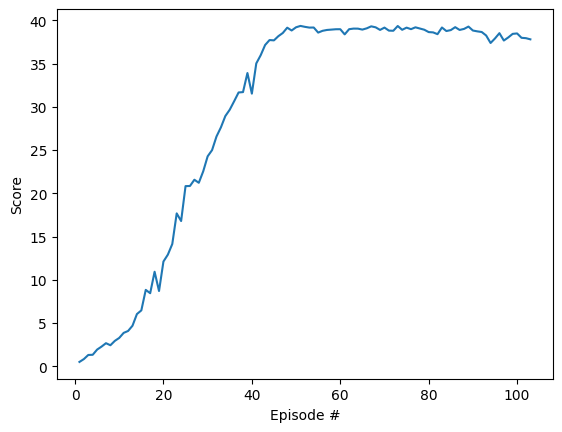

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()